In [12]:
import torch
import sklearn
import os
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader,SubsetRandomSampler,Dataset
from sklearn.metrics import confusion_matrix
import time 
import torch.optim.lr_scheduler as lr_scheduler
# from torchvision import datasets,transforms

In [13]:
from sklearn.model_selection import KFold

In [14]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [15]:

data=pd.read_csv('dataset.csv')
df=pd.DataFrame(data)

In [16]:
df.head()

,f1,f2,f3,f4,f5,f6,f7,target
0,6,148,72,35,0,33.6,0.627,1
1,1,85,66,29,0,26.6,0.351,0
2,8,183,64,0,0,23.3,0.672,1
3,1,89,66,23,94,28.1,0.167,0
4,0,137,40,35,168,43.1,2.288,1


In [17]:
X=df.drop('target',axis=1)
X

,f1,f2,f3,f4,f5,f6,f7
0,6,148,72,35,0,33.6,0.627
1,1,85,66,29,0,26.6,0.351
2,8,183,64,0,0,23.3,0.672
3,1,89,66,23,94,28.1,0.167
4,0,137,40,35,168,43.1,2.288
...,...,...,...,...,...,...,...
761,9,89,62,0,0,22.5,e
762,10,101,76,48,180,d,0.171
763,2,122,70,27,b,36.8,0.34
764,c,121,72,23,112,26.2,0.245


In [18]:
X.dtypes

f1    object
f2    object
f3     int64
f4    object
f5    object
f6    object
f7    object
dtype: object

In [19]:
df['f6'].value_counts()

32      13
31.2    12
31.6    12
0       11
33.3    10
        ..
36.7     1
41.8     1
42.6     1
42.8     1
d        1
Name: f6, Length: 249, dtype: int64

In [20]:
enc=OneHotEncoder(handle_unknown='ignore')
X=enc.fit_transform(X)

In [21]:
enc.inverse_transform(X.toarray())

array([['6', '148', 72, ..., '0', '33.6', '0.627'],
       ['1', '85', 66, ..., '0', '26.6', '0.351'],
       ['8', '183', 64, ..., '0', '23.3', '0.672'],
       ...,
       ['2', '122', 70, ..., 'b', '36.8', '0.34'],
       ['c', '121', 72, ..., '112', '26.2', '0.245'],
       ['1', '126', 60, ..., '0', '30.1', '0.349']], dtype=object)

In [22]:
Y=df['target']
sc=StandardScaler()
X=sc.fit_transform(X.toarray())
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state = 1,stratify = df["target"])

In [23]:
device='mps' if torch.backends.mps.is_available() else 'cpu'
print(f'{device}')

mps


In [24]:
import math

In [25]:
print(torch.backends.mps.is_available())

True


In [26]:
print(torch.backends.mps.is_built())

True


In [27]:
device=torch.device('cpu')

In [28]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork,self).__init__()
        self.flatten=nn.Flatten()
        self.linear_relu_stack=nn.Sequential(
            nn.Linear(1206,512),
            nn.ReLU(),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256,256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
#             nn.Linear(128,64),
#             nn.ReLU(),
#             nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,1)
        )
        self.sigmoid=nn.Sigmoid()
    def forward(self, x):
        x = self.flatten(x)
        logits = self.sigmoid(self.linear_relu_stack(x))
        return torch.reshape(logits,(-1,))
    
    

In [50]:
model = NeuralNetwork().to(device) 
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1206, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): ReLU()
    (10): ReLU()
    (11): Linear(in_features=64, out_features=1, bias=True)
  )
  (sigmoid): Sigmoid()
)


In [30]:
X = torch.rand(1, 1206, device=device)
print(X.dtype)
logits = model(X)
# pred_probab = nn.Softmax(dim=1)(logits) 
# y_pred = pred_probab.argmax(1) 
y_pred=logits
print(y_pred.shape)
print(y_pred.dtype)
print(f"Predicted class: {y_pred}")

torch.float32
torch.Size([1])
torch.float32
Predicted class: tensor([0.4925], grad_fn=<ViewBackward0>)


In [31]:
X_train.shape

(612, 1206)

In [32]:

from torch.utils.data import DataLoader, TensorDataset

X_train_tensor = torch.tensor(X_train)
Y_train_tensor = torch.tensor(Y_train.values)
X_train_tensor = X_train_tensor.to(torch.float32)
Y_train_tensor=Y_train_tensor.type(torch.float32)
dataset = TensorDataset(X_train_tensor, Y_train_tensor)

batch_size = 5
batch_size2=X_train.shape[0]
batch_size3=X_test.shape[0]
training_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [33]:
X_train_tensor.dtype

torch.float32

In [34]:
X_test_tensor=torch.tensor(X_test)
X_test_tensor = X_test_tensor.to(torch.float32)
Y_test_tensor=torch.tensor(Y_test.values)
Y_test_tensor=Y_test_tensor.type(torch.float32)

In [35]:
testingdata=TensorDataset(X_test_tensor,Y_test_tensor)
testing_loader=DataLoader(testingdata,batch_size=batch_size,shuffle=False)


In [36]:
len(training_loader)

123

In [51]:
loss_fn= torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01,momentum=0.8)

def train_one_epoch(epoch_index):
    
    running_loss = 0.
    last_loss = 0.
    num_correct=0
    for i, data in enumerate(training_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        predictions=(outputs>=0.5)
        num_correct+=(predictions==labels).sum()
#         if i % 20 == 19:
#             last_loss = running_loss/19  
# #            print('  batch {} loss: {}'.format(i + 1, last_loss))
# #             tb_x = epoch_index * len(training_loader) + i + 1
# #             tb_writer.add_scalar('Loss/train', last_loss, tb_x)
#             running_loss = 0
    return [running_loss,num_correct]

In [52]:
testing_best_loss=100000000
epoch_current=1
epochs=10
num_correct=0
num_samples=0
test_epoch=[]
train_epoch=[]
y_prediction=[]
y_true=[]
for epoch in range(epochs):
    num_correct=0
    num_samples=0
    print(f'current epoch is {epoch_current}')
    model.train(True)
    ans=train_one_epoch(epoch_current)
    model.train(False)
    print(f'training loss is {ans[0]}')
    testing_loss=0
    total_testing_loss=0
    for i,testdata in enumerate(testing_loader):
        testinputs,testlabels=testdata
        testoutputs=model(testinputs)
        testloss=loss_fn(testoutputs,testlabels)
        total_testing_loss+=testloss
        avg_testing_loss=total_testing_loss/(i+1)
        predictions=(testoutputs>=0.5)
        num_correct+=(predictions==testlabels).sum()
        num_samples+=predictions.size(0)
        if (avg_testing_loss<testing_best_loss):
            testing_best_loss=avg_testing_loss
            best_model=model.state_dict()
            predictions=(testoutputs>0.5)
            correct_ones=((predictions==testlabels).sum())/(testlabels.size(dim=0))
    test_epoch.append(num_correct.item())
    train_epoch.append(ans[1])
    epoch_current+=1
# for i,testdata in enumerate(testing_loader):
#     testinputs,testlabels=testdata
#     testoutputs=best_model(testinputs)
#     predictions=(testoutputs>0.5)
#     num_correct_final+=(predictions==testlabels).sum()
    
print(testing_best_loss)
print(num_correct)
print(test_epoch)
print(correct_ones*100)
torch.save(best_model,f'NN_part1.h5')    

current epoch is 1
training loss is 80.91609945893288
current epoch is 2
training loss is 79.7540884912014
current epoch is 3
training loss is 79.65566515922546
current epoch is 4
training loss is 78.84028080105782
current epoch is 5
training loss is 75.97668394446373
current epoch is 6
training loss is 51.37436749506742
current epoch is 7
training loss is 20.84491809323663
current epoch is 8
training loss is 10.473737401145627
current epoch is 9
training loss is 3.0819996841892134
current epoch is 10
training loss is 1.7807531184807885
tensor(0.2764, grad_fn=<DivBackward0>)
tensor(92)
[100, 100, 100, 100, 100, 96, 97, 99, 91, 92]
tensor(80.)


In [54]:
test_epoch=[ele/120 for ele in test_epoch]

train_epoch=[ele/612 for ele in train_epoch]

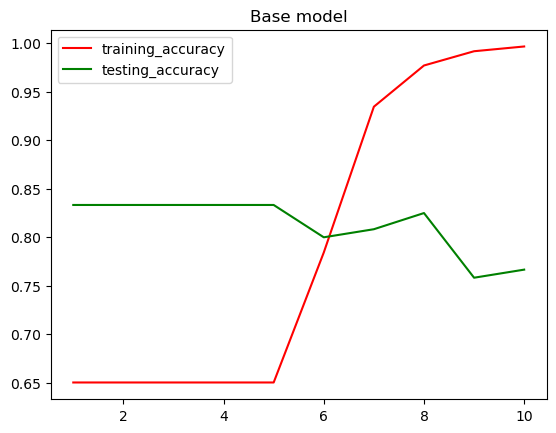

In [58]:
epochs=range(1,11)
plt.plot(epochs,train_epoch,'r',label='training_accuracy')
plt.plot(epochs,test_epoch,'g',label='testing_accuracy')
plt.title('Base model')
plt.legend()
plt.show()

In [83]:
#confmat=ConfusionMatrix(task='binary',num_classes=2)
x_test,y_test=next(iter(testing_loader))
y_pred=model(x_test)
print((y_pred.round().reshape(-1)==y_test).sum())
print(y_pred.shape)
#confusion_matrix(y_prediction,Y_test)

tensor(4)
torch.Size([5])


In [2]:
import platform
print(platform.platform())

macOS-12.3-arm64-arm-64bit


# We got a 86.667% accurate model.

In [219]:
testlabels.shape

torch.Size([4])

In [325]:
confusion_matrix(y_pred.round().reshape(-1).detach(),y_test)

array([[99, 54],
       [ 1,  0]])

In [282]:
len(testing_loader)

31

In [292]:
y_pred.round().reshape(-1).detach()

tensor([1., 0., 0., 0., 0.])

In [76]:
y_test.size(dim=0)

77.0

# Part 2 Optimizing NN

Let's start with dropout

In [70]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork,self).__init__()
        self.flatten=nn.Flatten()
        self.linear_relu_stack=nn.Sequential(
            nn.Linear(1206,512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256,256),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,1)
        )
        self.sigmoid=nn.Sigmoid()
    def forward(self, x):
        x = self.flatten(x)
        logits = self.sigmoid(self.linear_relu_stack(x))
        return torch.reshape(logits,(-1,))



In [71]:
model1 = NeuralNetwork().to(device) 
print(model1)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1206, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=256, bias=True)
    (6): ReLU()
    (7): Dropout(p=0.25, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): Dropout(p=0.25, inplace=False)
    (11): Linear(in_features=128, out_features=128, bias=True)
    (12): ReLU()
    (13): Linear(in_features=128, out_features=64, bias=True)
    (14): ReLU()
    (15): Linear(in_features=64, out_features=64, bias=True)
    (16): ReLU()
    (17): Linear(in_features=64, out_features=1, bias=True)
  )
  (sigmoid): Sigmoid()
)


In [72]:
loss_fn= torch.nn.BCELoss()

In [73]:
optimizer = torch.optim.SGD(model1.parameters(), lr=0.01)

In [74]:


def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.
    num_correct=0
    for i, data in enumerate(training_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model1(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        predictions=(outputs>=0.5)
        num_correct+=(predictions==labels).sum()
#         if i % 20 == 19:
#             last_loss = running_loss/19  
# #            print('  batch {} loss: {}'.format(i + 1, last_loss))
# #             tb_x = epoch_index * len(training_loader) + i + 1
# #             tb_writer.add_scalar('Loss/train', last_loss, tb_x)
#             running_loss = 0
    return [running_loss,num_correct]

In [75]:
testing_best_loss=100000000
epoch_current=1
epochs=10
num_correct=0
num_samples=0
test_epoch=[]
train_epoch=[]
y_prediction=[]
y_true=[]
for epoch in range(epochs):
    num_correct=0
    num_samples=0
    print(f'current epoch is {epoch_current}')
    model1.train(True)
    ans=train_one_epoch(epoch_current)
    model1.train(False)
    print(f'training loss is {ans[0]}')
    testing_loss=0
    total_testing_loss=0
    for i,testdata in enumerate(testing_loader):
        testinputs,testlabels=testdata
        testoutputs=model1(testinputs)
        testloss=loss_fn(testoutputs,testlabels)
        total_testing_loss+=testloss
        avg_testing_loss=total_testing_loss/(i+1)
        predictions=(testoutputs>=0.5)
        num_correct+=(predictions==testlabels).sum()
        num_samples+=predictions.size(0)
        if (avg_testing_loss<testing_best_loss):
            testing_best_loss=avg_testing_loss
            best_model=model1.state_dict()
            predictions=(testoutputs>0.5)
            correct_ones=((predictions==testlabels).sum())/(testlabels.size(dim=0))
    test_epoch.append(num_correct.item())
    train_epoch.append(ans[1])
    epoch_current+=1
# for i,testdata in enumerate(testing_loader):
#     testinputs,testlabels=testdata
#     testoutputs=best_model(testinputs)
#     predictions=(testoutputs>0.5)
#     num_correct_final+=(predictions==testlabels).sum()
    
print(testing_best_loss)
print(num_correct)
print(test_epoch)
print(correct_ones*100)
# torch.save(best_model,f'NN_part1.h5') 

current epoch is 1
training loss is 83.18215781450272
current epoch is 2
training loss is 80.98051136732101
current epoch is 3
training loss is 80.26014223694801
current epoch is 4
training loss is 79.93876883387566
current epoch is 5
training loss is 79.63522580265999
current epoch is 6
training loss is 79.74299135804176
current epoch is 7
training loss is 79.55480355024338
current epoch is 8
training loss is 79.53055199980736
current epoch is 9
training loss is 79.52616104483604
current epoch is 10
training loss is 79.52743822336197
tensor(0.4332, grad_fn=<DivBackward0>)
tensor(100)
[100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
tensor(100.)


Next fine tuning the Adam optimizer

In [76]:
test_epoch=[ele/120 for ele in test_epoch]

train_epoch=[ele/600 for ele in train_epoch]

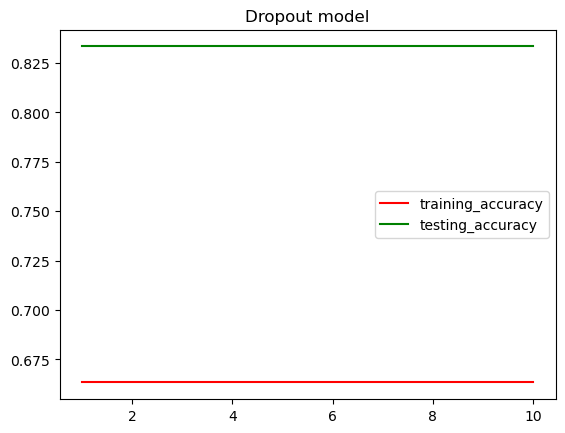

In [77]:
epochs=range(1,11)
plt.plot(epochs,train_epoch,'r',label='training_accuracy')
plt.plot(epochs,test_epoch,'g',label='testing_accuracy')
plt.title('Dropout model')
plt.legend()
plt.show()

In [82]:
optimizer=torch.optim.Adam(model1.parameters(),lr=0.0001)

In [347]:
print(testing_best_loss)
print(num_correct)
print(correct_epoch)
print(num_samples)

tensor(12.0612, grad_fn=<DivBackward0>)
tensor(87)
[tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(87)]
154


Next fine tuning the Activation Function

We have used sigmoid activation function let's use the softmax with two classes

In [93]:
# class NeuralNetwork(nn.Module):
#     def __init__(self):
#         super(NeuralNetwork,self).__init__()
#         self.flatten=nn.Flatten()
#         self.layer1=nn.Linear(1206,256)
#         self.act1=nn.ReLU()
#         self.dropout1=nn.Dropout(0.25)
#         self.layer2=nn.Linear(256,256)
#         self.act2=nn.ReLU()
#         self.dropout2=nn.Dropout(0.25)
#         self.layer3=nn.Linear(256,256)
#         self.act3=nn.ReLU()
#         self.layer4=nn.Linear(256,2)
#     def forward(self, x):
#         x = self.flatten(x)
#         x=self.act1(self.layer1(x))
#         x=self.dropout1(x)
#         x=self.act2(self.layer2(x))
#         x=self.dropout2(x)
#         x=self.act3(self.layer3(x))
#         logits = self.sigmoid(self.layer2(x))
#         logits=torch.reshape(logits,(-1,))
#         y_pred=nn.softmax(dim=1)(logits)
#         return y_pred.argmax(1)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork,self).__init__()
        self.flatten=nn.Flatten()
        self.linear_relu_stack=nn.Sequential(
            nn.Linear(1206,512),
            nn.Sigmoid(),
            nn.Dropout(0.25),
            nn.Linear(512,256),
            nn.Sigmoid(),
            nn.Linear(256,256),
            nn.Sigmoid(),
            nn.Dropout(0.25),
            nn.Linear(256,128),
            nn.Sigmoid(),
            nn.Dropout(0.25),
            nn.Linear(128,128),
            nn.Sigmoid(),
            nn.Linear(128,64),
            nn.Sigmoid(),
            nn.Linear(64,64),
            nn.Sigmoid(),
            nn.Linear(64,1)
        )
        self.sigmoid=nn.Sigmoid()
    def forward(self, x):
        x = self.flatten(x)
        logits = self.sigmoid(self.linear_relu_stack(x))
        return torch.reshape(logits,(-1,))

In [97]:
model2=NeuralNetwork().to(device)
print(model2)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1206, out_features=512, bias=True)
    (1): Sigmoid()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=256, out_features=256, bias=True)
    (6): Sigmoid()
    (7): Dropout(p=0.25, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): Sigmoid()
    (10): Dropout(p=0.25, inplace=False)
    (11): Linear(in_features=128, out_features=128, bias=True)
    (12): Sigmoid()
    (13): Linear(in_features=128, out_features=64, bias=True)
    (14): Sigmoid()
    (15): Linear(in_features=64, out_features=64, bias=True)
    (16): Sigmoid()
    (17): Linear(in_features=64, out_features=1, bias=True)
  )
  (sigmoid): Sigmoid()
)


In [98]:
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.
    num_correct=0
    for i, data in enumerate(training_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model2(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        predictions=(outputs>=0.5)
        num_correct+=(predictions==labels).sum()
#         if i % 1 == 0:
#             last_loss = running_loss  
# #            print('  batch {} loss: {}'.format(i + 1, last_loss))
# #             tb_x = epoch_index * len(training_loader) + i + 1
# #             tb_writer.add_scalar('Loss/train', last_loss, tb_x)
#             running_loss = 0
    return [running_loss,num_correct]

In [99]:
testing_best_loss=100000000
epoch_current=1
epochs=10
num_correct=0
num_samples=0
test_epoch=[]
train_epoch=[]
y_prediction=[]
y_true=[]
for epoch in range(epochs):
    num_correct=0
    num_samples=0
    print(f'current epoch is {epoch_current}')
    model2.train(True)
    ans=train_one_epoch(epoch_current)
    model2.train(False)
    print(f'training loss is {ans[0]}')
    testing_loss=0
    total_testing_loss=0
    for i,testdata in enumerate(testing_loader):
        testinputs,testlabels=testdata
        testoutputs=model2(testinputs)
        testloss=loss_fn(testoutputs,testlabels)
        total_testing_loss+=testloss
        avg_testing_loss=total_testing_loss/(i+1)
        predictions=(testoutputs>=0.5)
        num_correct+=(predictions==testlabels).sum()
        num_samples+=predictions.size(0)
        if (avg_testing_loss<testing_best_loss):
            testing_best_loss=avg_testing_loss
            best_model=model2.state_dict()
            predictions=(testoutputs>0.5)
            correct_ones=((predictions==testlabels).sum())/(testlabels.size(dim=0))
    test_epoch.append(num_correct.item())
    train_epoch.append(ans[1])
    epoch_current+=1
# for i,testdata in enumerate(testing_loader):
#     testinputs,testlabels=testdata
#     testoutputs=best_model(testinputs)
#     predictions=(testoutputs>0.5)
#     num_correct_final+=(predictions==testlabels).sum()
    
print(testing_best_loss)
print(num_correct)
print(test_epoch)
print(correct_ones*100)

current epoch is 1
training loss is 79.88311877846718
current epoch is 2
training loss is 79.73528149724007
current epoch is 3
training loss is 80.03014302253723
current epoch is 4
training loss is 79.88618221879005
current epoch is 5
training loss is 79.88396954536438
current epoch is 6
training loss is 79.73727402091026
current epoch is 7
training loss is 79.8855028450489
current epoch is 8
training loss is 79.73710405826569
current epoch is 9
training loss is 79.73631423711777
current epoch is 10
training loss is 79.88551068305969
tensor(0.4766, grad_fn=<DivBackward0>)
tensor(100)
[100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
tensor(100.)


In [101]:
test_epoch=[ele/120 for ele in test_epoch]

In [100]:
train_epoch=[ele/600 for ele in train_epoch]

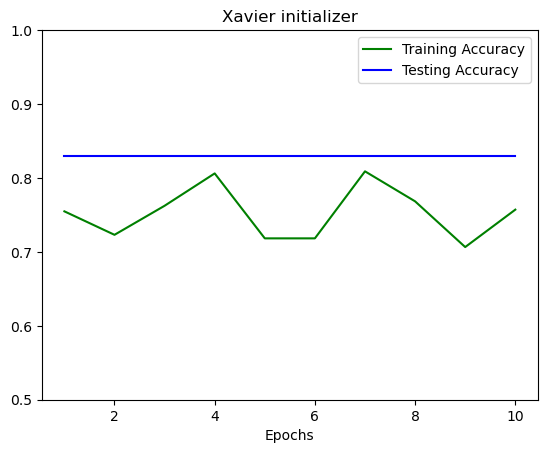

In [109]:
epochs = range(1, 11)

plt.plot(epochs, training_acc, 'g', label='Training Accuracy')
plt.plot(epochs, testing_acc, 'b', label='Testing Accuracy')


plt.xlabel('Epochs')
plt.title('Xavier initializer')
plt.ylim(0.5, 1.0)


plt.legend()

plt.show()


Next fine tuning the loss function

We are picking the PoissonNLL loss function instead of the binary cross entropy function.


In [367]:
loss_fn=torch.nn.PoissonNLLLoss()

In [359]:
model3=NeuralNetwork().to(device)
print(model3)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer1): Linear(in_features=1206, out_features=256, bias=True)
  (act1): ReLU()
  (dropout1): Dropout(p=0.25, inplace=False)
  (layer2): Linear(in_features=256, out_features=256, bias=True)
  (act2): ReLU()
  (dropout2): Dropout(p=0.25, inplace=False)
  (layer3): Linear(in_features=256, out_features=256, bias=True)
  (act3): ReLU()
  (layer4): Linear(in_features=256, out_features=2, bias=True)
)


In [370]:
print(testing_best_loss)
print(num_correct)
print(correct_epoch)
print(num_samples)

tensor(1.3684, grad_fn=<DivBackward0>)
tensor(88)
[tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88), tensor(88)]
154


In [144]:
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.
    for i, data in enumerate(training_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model4(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 20 == 19:
            last_loss = running_loss  
#            print('  batch {} loss: {}'.format(i + 1, last_loss))
#             tb_x = epoch_index * len(training_loader) + i + 1
#             tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0
    return last_loss

Using Xavier initialization as the 4th change in hyperparameter 

In [137]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork,self).__init__()
        self.flatten=nn.Flatten()
        self.layer1=nn.Linear(1206,512)
        nn.init.xavier_normal_(self.layer1.weight)
        self.act1=nn.ReLU()
        self.dropout1=nn.Dropout(0.25)
        self.layer2=nn.Linear(512,256)
        nn.init.xavier_normal_(self.layer2.weight)
        self.act2=nn.ReLU()
        self.dropout2=nn.Dropout(0.25)
        self.layer3=nn.Linear(256,256)
        nn.init.xavier_normal_(self.layer3.weight)
        self.act3=nn.ReLU()
        self.dropout3=nn.Dropout(0.25)
        self.layer4=nn.Linear(256,128)
        self.act4=nn.ReLU()
        nn.init.xavier_normal_(self.layer4.weight)
        self.dropout4=nn.Dropout(0.25)
        self.layer5=nn.Linear(128,128)
        self.act5=nn.ReLU()
        nn.init.xavier_normal_(self.layer5.weight)
        self.dropout5=nn.Dropout(0.25)
        self.layer6=nn.Linear(128,64)
        self.act6=nn.ReLU()
        nn.init.xavier_normal_(self.layer6.weight)
        self.dropout6=nn.Dropout(0.25)
        self.layer7=nn.Linear(64,64)
        self.act7=nn.ReLU()
        nn.init.xavier_normal_(self.layer7.weight)
        self.dropout7=nn.Dropout(0.25)
        self.layer8=nn.Linear(64,1)
        nn.init.xavier_normal_(self.layer8.weight)
        self.sigmoid=nn.Sigmoid()
    def forward(self, x):
        x = self.flatten(x)
        x=self.act1(self.layer1(x))
        x=self.dropout1(x)
        x=self.act2(self.layer2(x))
        x=self.dropout2(x)
        x=self.act3(self.layer3(x))
        x=self.dropout3(x)
        x=self.act4(self.layer4(x))
        x=self.dropout4(x)
        x=self.act5(self.layer5(x))
        x=self.dropout5(x)
        x=self.act6(self.layer6(x))
        x=self.dropout6(x)
        x=self.act7(self.layer7(x))
        x=self.dropout7(x)
        x=self.layer8(x)
        logits = self.sigmoid(x)
        return torch.reshape(logits,(-1,))

In [138]:
model4=NeuralNetwork().to(device)
print(model4)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer1): Linear(in_features=1206, out_features=512, bias=True)
  (act1): ReLU()
  (dropout1): Dropout(p=0.25, inplace=False)
  (layer2): Linear(in_features=512, out_features=256, bias=True)
  (act2): ReLU()
  (dropout2): Dropout(p=0.25, inplace=False)
  (layer3): Linear(in_features=256, out_features=256, bias=True)
  (act3): ReLU()
  (dropout3): Dropout(p=0.25, inplace=False)
  (layer4): Linear(in_features=256, out_features=128, bias=True)
  (act4): ReLU()
  (dropout4): Dropout(p=0.25, inplace=False)
  (layer5): Linear(in_features=128, out_features=128, bias=True)
  (act5): ReLU()
  (dropout5): Dropout(p=0.25, inplace=False)
  (layer6): Linear(in_features=128, out_features=64, bias=True)
  (act6): ReLU()
  (dropout6): Dropout(p=0.25, inplace=False)
  (layer7): Linear(in_features=64, out_features=64, bias=True)
  (act7): ReLU()
  (dropout7): Dropout(p=0.25, inplace=False)
  (layer8): Linear(in_features=64, out_features=1, b

In [145]:
testing_best_loss=100000000
epoch_current=1
epochs=10
num_correct=0
num_samples=0
correct_epoch=[]
y_prediction=[]
y_true=[]
for epoch in range(epochs):
    num_correct=0
    num_samples=0
    print(f'current epoch is {epoch_current}')
    model4.train(True)
    train_loss=train_one_epoch(epoch_current)
    model4.train(False)
    print(f'training loss is {train_loss}')
    testing_loss=0
    total_testing_loss=0
    for i,testdata in enumerate(testing_loader):
        testinputs,testlabels=testdata
        testoutputs=model4(testinputs)
        testloss=loss_fn(testoutputs,testlabels)
        total_testing_loss+=testloss
        avg_testing_loss=total_testing_loss/(i+1)
        predictions=(testoutputs>=0.5)
        num_correct+=(predictions==testlabels).sum()
        num_samples+=predictions.size(0)
        if (avg_testing_loss<testing_best_loss):
            testing_best_loss=avg_testing_loss
            best_model=model4.state_dict()
            predictions=(testoutputs>0.5)
            correct_ones=((predictions==testlabels).sum())/(testlabels.size(dim=0))
    correct_epoch.append(num_correct)
    epoch_current+=1
# for i,testdata in enumerate(testing_loader):
#     testinputs,testlabels=testdata
#     testoutputs=best_model(testinputs)
#     predictions=(testoutputs>0.5)
#     num_correct_final+=(predictions==testlabels).sum()
    
print(testing_best_loss)
print(num_correct)
print(correct_epoch)
print(correct_ones*100)

current epoch is 1
training loss is 15.816173017024994
current epoch is 2
training loss is 14.783052921295166
current epoch is 3
training loss is 14.6833136677742
current epoch is 4
training loss is 14.832689702510834
current epoch is 5
training loss is 15.187586605548859
current epoch is 6
training loss is 15.71987771987915
current epoch is 7
training loss is 15.061310887336731
current epoch is 8
training loss is 15.07891172170639
current epoch is 9
training loss is 15.10769635438919
current epoch is 10
training loss is 16.369083285331726
tensor(0.7303, grad_fn=<DivBackward0>)
tensor(54)
[tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54)]
tensor(40.)


Let's try kaming initalization 

In [182]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork,self).__init__()
        self.flatten=nn.Flatten()
        self.layer1=nn.Linear(1206,512)
        nn.init.xavier_normal_(self.layer1.weight)
        self.act1=nn.ReLU()
        self.dropout1=nn.Dropout(0.25)
        self.layer2=nn.Linear(512,256)
        nn.init.xavier_normal_(self.layer2.weight)
        self.act2=nn.ReLU()
        self.dropout2=nn.Dropout(0.25)
        self.layer3=nn.Linear(256,256)
        nn.init.xavier_normal_(self.layer3.weight)
        self.act3=nn.ReLU()
        self.dropout3=nn.Dropout(0.25)
        self.layer4=nn.Linear(256,128)
        self.act4=nn.ReLU()
        nn.init.xavier_normal_(self.layer4.weight)
        self.dropout4=nn.Dropout(0.25)
        self.layer5=nn.Linear(128,128)
        self.act5=nn.ReLU()
        nn.init.xavier_normal_(self.layer5.weight)
        self.dropout5=nn.Dropout(0.25)
        self.layer6=nn.Linear(128,64)
        self.act6=nn.ReLU()
        nn.init.xavier_normal_(self.layer6.weight)
        self.dropout6=nn.Dropout(0.25)
        self.layer7=nn.Linear(64,64)
        self.act7=nn.ReLU()
        nn.init.xavier_normal_(self.layer7.weight)
        self.dropout7=nn.Dropout(0.25)
        self.layer8=nn.Linear(64,1)
        nn.init.xavier_normal_(self.layer8.weight)
        self.sigmoid=nn.Sigmoid()
    def forward(self, x):
        x = self.flatten(x)
        x=self.act1(self.layer1(x))
        x=self.dropout1(x)
        x=self.act2(self.layer2(x))
        x=self.dropout2(x)
        x=self.act3(self.layer3(x))
        x=self.dropout3(x)
        x=self.act4(self.layer4(x))
        x=self.dropout4(x)
        x=self.act5(self.layer5(x))
        x=self.dropout5(x)
        x=self.act6(self.layer6(x))
        x=self.dropout6(x)
        x=self.act7(self.layer7(x))
        x=self.dropout7(x)
        x=self.layer8(x)
        logits = self.sigmoid(x)
        return torch.reshape(logits,(-1,))

In [183]:
model5=NeuralNetwork().to(device)
print(model5)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer1): Linear(in_features=1206, out_features=512, bias=True)
  (act1): ReLU()
  (dropout1): Dropout(p=0.25, inplace=False)
  (layer2): Linear(in_features=512, out_features=256, bias=True)
  (act2): ReLU()
  (dropout2): Dropout(p=0.25, inplace=False)
  (layer3): Linear(in_features=256, out_features=256, bias=True)
  (act3): ReLU()
  (dropout3): Dropout(p=0.25, inplace=False)
  (layer4): Linear(in_features=256, out_features=128, bias=True)
  (act4): ReLU()
  (dropout4): Dropout(p=0.25, inplace=False)
  (layer5): Linear(in_features=128, out_features=128, bias=True)
  (act5): ReLU()
  (dropout5): Dropout(p=0.25, inplace=False)
  (layer6): Linear(in_features=128, out_features=64, bias=True)
  (act6): ReLU()
  (dropout6): Dropout(p=0.25, inplace=False)
  (layer7): Linear(in_features=64, out_features=64, bias=True)
  (act7): ReLU()
  (dropout7): Dropout(p=0.25, inplace=False)
  (layer8): Linear(in_features=64, out_features=1, b

In [184]:
optimizer=torch.optim.Adam(model5.parameters(),lr=0.0001)

In [185]:
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.
    for i, data in enumerate(training_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model5(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 20 == 19:
            last_loss = running_loss/19  
#            print('  batch {} loss: {}'.format(i + 1, last_loss))
#             tb_x = epoch_index * len(training_loader) + i + 1
#             tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0
    return last_loss

In [186]:
testing_best_loss=100000000
epoch_current=1
epochs=20
num_correct=0
num_samples=0
correct_epoch=[]
y_prediction=[]
y_true=[]
for epoch in range(epochs):
    num_correct=0
    num_samples=0
    t0=time.time()
    print(f'current epoch is {epoch_current}')
    model5.train(True)
    train_loss=train_one_epoch(epoch_current)
    model5.train(False)
    print(f'training loss is {train_loss}')
    testing_loss=0
    total_testing_loss=0
    for i,testdata in enumerate(testing_loader):
        testinputs,testlabels=testdata
        testoutputs=model5(testinputs)
        testloss=loss_fn(testoutputs,testlabels)
        total_testing_loss+=testloss
        avg_testing_loss=total_testing_loss/(i+1)
        predictions=(testoutputs>=0.5)
        num_correct+=(predictions==testlabels).sum()
        num_samples+=predictions.size(0)
        if (avg_testing_loss<testing_best_loss):
            testing_best_loss=avg_testing_loss
            best_model=model5.state_dict()
            predictions=(testoutputs>0.5)
            correct_ones=((predictions==testlabels).sum())/(testlabels.size(dim=0))
    correct_epoch.append(num_correct)
    epoch_current+=1
# for i,testdata in enumerate(testing_loader):
#     testinputs,testlabels=testdata
#     testoutputs=best_model(testinputs)
#     predictions=(testoutputs>0.5)
#     num_correct_final+=(predictions==testlabels).sum()
model5_time=time.time()-t0
print(f'final time={model5_time}')    
print(testing_best_loss)
print(num_correct)
print(correct_epoch)
print(correct_ones*100)

current epoch is 1
training loss is 0.7781985292309209
current epoch is 2
training loss is 0.7072105360658545
current epoch is 3
training loss is 0.7149259714703811
current epoch is 4
training loss is 0.6520158977884996
current epoch is 5
training loss is 0.7526882165356686
current epoch is 6
training loss is 0.651555669935126
current epoch is 7
training loss is 0.6448096962351548
current epoch is 8
training loss is 0.6398639835809407
current epoch is 9
training loss is 0.5256085356599406
current epoch is 10
training loss is 0.5742594521296652
current epoch is 11
training loss is 0.49647403312356847
current epoch is 12
training loss is 0.43340559421401276
current epoch is 13
training loss is 0.26172586108900997
current epoch is 14
training loss is 0.19967365528971545
current epoch is 15
training loss is 0.13313475844303244
current epoch is 16
training loss is 0.052175509058686564
current epoch is 17
training loss is 0.011208456112255686
current epoch is 18
training loss is 0.0224369415

### Step 3

After using Xavier initilization this is not ideal for our case 

The best of all models is our base model  features is listed below 

In [331]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork,self).__init__()
        self.flatten=nn.Flatten()
        self.layer1=nn.Linear(1206,512)
        nn.init.xavier_normal_(self.layer1.weight)
        self.act1=nn.ReLU()
        self.dropout1=nn.Dropout(0.25)
        self.layer2=nn.Linear(512,256)
        nn.init.xavier_normal_(self.layer2.weight)
        self.act2=nn.ReLU()
        self.dropout2=nn.Dropout(0.25)
        self.layer3=nn.Linear(256,256)
        nn.init.xavier_normal_(self.layer3.weight)
        self.act3=nn.ReLU()
        self.dropout3=nn.Dropout(0.25)
        self.layer4=nn.Linear(256,128)
        self.act4=nn.ReLU()
        nn.init.xavier_normal_(self.layer4.weight)
        self.dropout4=nn.Dropout(0.25)
        self.layer5=nn.Linear(128,128)
        self.act5=nn.ReLU()
        nn.init.xavier_normal_(self.layer5.weight)
        self.dropout5=nn.Dropout(0.25)
        self.layer6=nn.Linear(128,64)
        self.act6=nn.ReLU()
        nn.init.xavier_normal_(self.layer6.weight)
        self.dropout6=nn.Dropout(0.25)
        self.layer7=nn.Linear(64,64)
        self.act7=nn.ReLU()
        nn.init.xavier_normal_(self.layer7.weight)
        self.dropout7=nn.Dropout(0.25)
        self.layer8=nn.Linear(64,1)
        nn.init.xavier_normal_(self.layer8.weight)
        self.sigmoid=nn.Sigmoid()
    def forward(self, x):
        x = self.flatten(x)
        x=self.act1(self.layer1(x))
        x=self.dropout1(x)
        x=self.act2(self.layer2(x))
        x=self.dropout2(x)
        x=self.act3(self.layer3(x))
        x=self.dropout3(x)
        x=self.act4(self.layer4(x))
        x=self.dropout4(x)
        x=self.act5(self.layer5(x))
        x=self.dropout5(x)
        x=self.act6(self.layer6(x))
        x=self.dropout6(x)
        x=self.act7(self.layer7(x))
        x=self.dropout7(x)
        x=self.layer8(x)
        logits = self.sigmoid(x)
        return torch.reshape(logits,(-1,))

In [332]:
base_model=NeuralNetwork().to(device)
print(base_model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer1): Linear(in_features=1206, out_features=512, bias=True)
  (act1): ReLU()
  (dropout1): Dropout(p=0.25, inplace=False)
  (layer2): Linear(in_features=512, out_features=256, bias=True)
  (act2): ReLU()
  (dropout2): Dropout(p=0.25, inplace=False)
  (layer3): Linear(in_features=256, out_features=256, bias=True)
  (act3): ReLU()
  (dropout3): Dropout(p=0.25, inplace=False)
  (layer4): Linear(in_features=256, out_features=128, bias=True)
  (act4): ReLU()
  (dropout4): Dropout(p=0.25, inplace=False)
  (layer5): Linear(in_features=128, out_features=128, bias=True)
  (act5): ReLU()
  (dropout5): Dropout(p=0.25, inplace=False)
  (layer6): Linear(in_features=128, out_features=64, bias=True)
  (act6): ReLU()
  (dropout6): Dropout(p=0.25, inplace=False)
  (layer7): Linear(in_features=64, out_features=64, bias=True)
  (act7): ReLU()
  (dropout7): Dropout(p=0.25, inplace=False)
  (layer8): Linear(in_features=64, out_features=1, b

The optimizer is Adam

In [277]:
optimizer=torch.optim.SGD(base_model.parameters(),lr=0.01)

This is the base model with no optimisation methods used

In [300]:
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.
    for i, data in enumerate(training_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = base_model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 20 == 19:
            last_loss = running_loss/19  
#            print('  batch {} loss: {}'.format(i + 1, last_loss))
#             tb_x = epoch_index * len(training_loader) + i + 1
#             tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0
    return running_loss

In [302]:
testing_best_loss=100000000
epoch_current=1
epochs=100
num_correct=0
num_samples=0
correct_epoch=[]
y_prediction=[]
y_true=[]
training_losses_base_model=[]
testing_losses_base_model=[]
for epoch in range(epochs):
    num_correct=0
    num_samples=0
    t0=time.time()
    print(f'current epoch is {epoch_current}')
    model5.train(True)
    train_loss=train_one_epoch(epoch_current)
    model5.train(False)
    print(f'training loss is {train_loss}')
    testing_loss=0
    total_testing_loss=0
    for i,testdata in enumerate(testing_loader):
        testinputs,testlabels=testdata
        testoutputs=model5(testinputs)
        testloss=loss_fn(testoutputs,testlabels)
        total_testing_loss+=testloss
        avg_testing_loss=total_testing_loss/(i+1)
        predictions=(testoutputs>=0.5)
        num_correct+=(predictions==testlabels).sum()
        num_samples+=predictions.size(0)
        if (avg_testing_loss<testing_best_loss):
            testing_best_loss=avg_testing_loss
            best_model=model5.state_dict()
            predictions=(testoutputs>0.5)
            correct_ones=((predictions==testlabels).sum())/(testlabels.size(dim=0))
    correct_epoch.append(num_correct)
    training_losses_base_model.append(train_loss)
    testing_losses_base_model.append(avg_testing_loss)
    epoch_current+=1
# for i,testdata in enumerate(testing_loader):
#     testinputs,testlabels=testdata
#     testoutputs=best_model(testinputs)
#     predictions=(testoutputs>0.5)
#     num_correct_final+=(predictions==testlabels).sum()
model5_time=time.time()-t0
print(f'final time={model5_time}')    
print(testing_best_loss)
print(num_correct)
print(correct_epoch)
print(correct_ones*100)


current epoch is 1
training loss is 0.6895385384559631
current epoch is 2
training loss is 1.3243873417377472
current epoch is 3
training loss is 0.8713246881961823
current epoch is 4
training loss is 0.7699929028749466
current epoch is 5
training loss is 0.8240740299224854
current epoch is 6
training loss is 0.6618585884571075
current epoch is 7
training loss is 0.6554736457765102
current epoch is 8
training loss is 0.578304735943675
current epoch is 9
training loss is 1.0012053549289703
current epoch is 10
training loss is 0.9230711460113525
current epoch is 11
training loss is 0.6344012171030045
current epoch is 12
training loss is 1.1952955722808838
current epoch is 13
training loss is 0.7484656348824501
current epoch is 14
training loss is 0.9689759314060211
current epoch is 15
training loss is 0.7203518003225327
current epoch is 16
training loss is 0.5723278820514679
current epoch is 17
training loss is 0.49010345339775085
current epoch is 18
training loss is 0.7770448923110962
c

Let's start with early stopping and if the validation error doesn't improve after 3 epoch the loop is going to break

In [190]:
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.
    for i, data in enumerate(training_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = base_model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 20 == 19:
            last_loss = running_loss/19  
#            print('  batch {} loss: {}'.format(i + 1, last_loss))
#             tb_x = epoch_index * len(training_loader) + i + 1
#             tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0
    return last_loss

In [303]:
testing_best_loss=100000000
epoch_current=1
epochs=100
num_correct=0
num_samples=0
correct_epoch=[]
y_prediction=[]
y_true=[]
not_improving=0
training_losses_earlystopping=[]
testing_losses_earlystopping=[]
for epoch in range(epochs):
    t0=time.time()
    num_correct=0
    num_samples=0
    print(f'current epoch is {epoch_current}')
    base_model.train(True)
    train_loss=train_one_epoch(epoch_current)
    base_model.train(False)
    print(f'training loss is {train_loss}')
    testing_loss=0
    total_testing_loss=0
    for i,testdata in enumerate(testing_loader):
        testinputs,testlabels=testdata
        testoutputs=base_model(testinputs)
        testloss=loss_fn(testoutputs,testlabels)
        total_testing_loss+=testloss
        avg_testing_loss=total_testing_loss/(i+1)
        predictions=(testoutputs>=0.5)
        num_correct+=(predictions==testlabels).sum()
        num_samples+=predictions.size(0)
        if (avg_testing_loss<testing_best_loss):
            testing_best_loss=avg_testing_loss
            best_model=base_model.state_dict()
            predictions=(testoutputs>0.5)
            correct_ones=((predictions==testlabels).sum())/(testlabels.size(dim=0))
    training_losses_earlystopping.append(train_loss)
    testing_losses_earlystopping.append(avg_testing_loss)
    correct_epoch.append(num_correct)
    if(num_correct>max(correct_epoch)):
        not_improving=0
    else:
        not_improving+=1
    if(not_improving==5):
        break
    
    epoch_current+=1
# for i,testdata in enumerate(testing_loader):
#     testinputs,testlabels=testdata
#     testoutputs=best_model(testinputs)
#     predictions=(testoutputs>0.5)
#     num_correct_final+=(predictions==testlabels).sum()
base_model1_time=time.time()-t0
print(f'time_taken is {base_model1_time}')
print(testing_best_loss)
print(num_correct)
print(correct_epoch)
print(correct_ones*100)

current epoch is 1
training loss is 0.6588260214775801
current epoch is 2
training loss is 1.58581081032753
current epoch is 3
training loss is 1.0951915383338928
current epoch is 4
training loss is 1.276029460132122
current epoch is 5
training loss is 1.0535112023353577
time_taken is 0.1870272159576416
tensor(0.3373, grad_fn=<DivBackward0>)
tensor(98)
[tensor(98), tensor(98), tensor(98), tensor(98), tensor(98)]
tensor(80.)


In [342]:
ans=[ele.detach().numpy() for ele in testing_losses_base_model]
ans2=[ele.detach().numpy() for ele in testing_losses_earlystopping]
ans2

[array(0.72146344, dtype=float32),
 array(0.721459, dtype=float32),
 array(0.72145575, dtype=float32),
 array(0.72144115, dtype=float32),
 array(0.72140014, dtype=float32)]

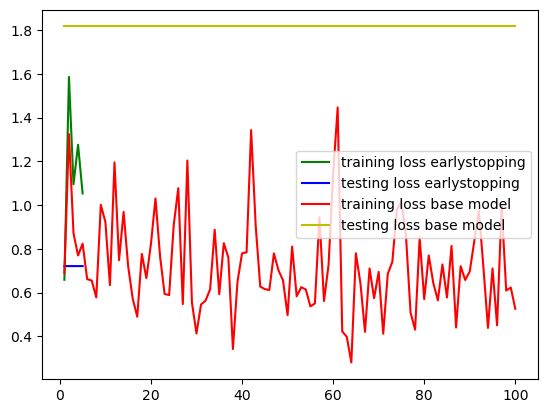

In [320]:
epochs=range(1,101)
epochs2=range(1,len(training_losses_earlystopping)+1)
plt.plot(epochs2,training_losses_earlystopping,'g',label='training loss earlystopping')
plt.plot(epochs2,ans2,'b',label='testing loss earlystopping')
plt.plot(epochs,training_losses_base_model,'r',label='training loss base model')
plt.plot(epochs,ans,'y',label='testing loss base model')
plt.legend()
plt.show()

The time difference between the two models is

In [193]:
model5_time-base_model1_time

0.2621908187866211

There is a significant change in time taken to train

Now let's look at k-fold cross validation.

In [321]:
class MyDataset(Dataset):
    def __init__(self,a,b):
        super().__init__()
        self.a=a
        self.b=b
    def __getitem__(self,index):
        return self.a[index],self.b[index]
    def __len__(self):
        ans=len(self.a)
        return ans

dataset=MyDataset(X_train,Y_train.values)

In [322]:
optimizer=torch.optim.Adam(base_model.parameters(),lr=0.0001)

In [323]:
k=KFold(n_splits=5,shuffle=True)

In [324]:
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.
    for i, data in enumerate(training_loader):
        inputs, labels = data
        optimizer.zero_grad()
        inputs=torch.tensor(inputs)
        inputs=inputs.to(torch.float32)
        labels=torch.tensor(labels)
        labels=labels.to(torch.float32)
        outputs = base_model(torch.tensor(inputs))
        loss = loss_fn(outputs, torch.tensor(labels))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 5 == 4:
            last_loss = running_loss/5  
#            print('  batch {} loss: {}'.format(i + 1, last_loss))
#             tb_x = epoch_index * len(training_loader) + i + 1
#             tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0
    return last_loss

In [325]:
accuracy=[]
testing_accuracy=[]
training_losses_kfold=[]
validation_losses_kfold=[]
for fold,(train_id,validation_id) in enumerate(k.split(dataset)):
    print(f'current fold is {fold}')
    training=SubsetRandomSampler(train_id)
    validation=SubsetRandomSampler(validation_id)
    training_loader=DataLoader(dataset,batch_size=5,sampler=training)
    validation_loader=DataLoader(dataset,batch_size=5,sampler=validation)
    testing_best_loss=100000000
    epoch_current=1
    epochs=20
    num_correct=0
    num_samples=0
    correct_epoch=[]
    y_prediction=[]
    y_true=[]
    not_improving=0
    for epoch in range(epochs):
        t0=time.time()
        num_correct=0
        num_samples=0
        test_num_correct=0
        test_num_samples=0
        print(f'current epoch is {epoch_current}')
        base_model.train(True)
        train_loss=train_one_epoch(epoch_current)
        base_model.train(False)
        print(f'training loss is {train_loss}')
        testing_loss=0
        total_testing_loss=0
        for i,testdata in enumerate(validation_loader):
            testinputs,testlabels=testdata
            testinputs=torch.tensor(testinputs)
            testinputs=testinputs.to(torch.float32)
            testlabels=torch.tensor(testlabels)
            testlabels=testlabels.to(torch.float32)
            testoutputs=base_model(testinputs)
            testloss=loss_fn(testoutputs,testlabels)
            total_testing_loss+=testloss
            avg_testing_loss=total_testing_loss/(i+1)
            predictions=(testoutputs>=0.5)
            num_correct+=(predictions==testlabels).sum()
            num_samples+=predictions.size(0)
            if (avg_testing_loss<testing_best_loss):
                testing_best_loss=avg_testing_loss
                best_model=base_model.state_dict()
                predictions=(testoutputs>0.5)
                correct_ones=((predictions==testlabels).sum())/(testlabels.size(dim=0))
        training_losses_kfold.append(train_loss)
        validation_losses_kfold.append(avg_testing_loss)
        correct_epoch.append(num_correct)
        accuracy.append(num_correct/num_samples*100)
        
        for j,testdata1 in enumerate(testing_loader):
            testinputs1,testlabels1=testdata1
            testoutputs1=base_model(testinputs1)
            predictions=(testoutputs1>=0.5)
            test_num_correct+=(predictions==testlabels1).sum()
            test_num_samples+=predictions.size(0)
        testing_accuracy.append(test_num_correct/test_num_samples*100)         
#         if(num_correct>max(correct_epoch)):
#             not_improving=0
#         else:
#             not_improving+=1
#         if(not_improving==3):
#             break

        epoch_current+=1
    base_model1_time=time.time()-t0
    print(f'time_taken is {base_model1_time}')
    print(testing_best_loss)
    print(num_correct)
    print(correct_epoch)
    print(correct_ones*100)
torch.save(best_model,f'kfold.h5')    
print(accuracy)    
print(testing_accuracy)

current fold is 0
current epoch is 1


/var/folders/ch/smc0q7m106q8yldyl_4tsr3w0000gn/T/ipykernel_53571/394998263.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs=torch.tensor(inputs)
/var/folders/ch/smc0q7m106q8yldyl_4tsr3w0000gn/T/ipykernel_53571/394998263.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels=torch.tensor(labels)
/var/folders/ch/smc0q7m106q8yldyl_4tsr3w0000gn/T/ipykernel_53571/394998263.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = base_model(torch.tensor(inputs))
/var/folders/ch/smc0q7m106q8yldyl_4tsr3w0000gn/T/ipykernel_5357

training loss is 0.3484165295958519
current epoch is 2


/var/folders/ch/smc0q7m106q8yldyl_4tsr3w0000gn/T/ipykernel_53571/2110347711.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testinputs=torch.tensor(testinputs)
/var/folders/ch/smc0q7m106q8yldyl_4tsr3w0000gn/T/ipykernel_53571/2110347711.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testlabels=torch.tensor(testlabels)


training loss is 0.4668454870581627
current epoch is 3
training loss is 0.13225932866334916
current epoch is 4
training loss is 0.09160376116633415
current epoch is 5
training loss is 0.08277884237468243
current epoch is 6
training loss is 0.05828417625743896
current epoch is 7
training loss is 0.033563155215233564
current epoch is 8
training loss is 0.018864680849947035
current epoch is 9
training loss is 0.010486593376845122
current epoch is 10
training loss is 0.0031246343336533756
current epoch is 11
training loss is 0.002899660402908921
current epoch is 12
training loss is 0.002531248566810973
current epoch is 13
training loss is 0.01829883476275427
current epoch is 14
training loss is 0.004113084229902597
current epoch is 15
training loss is 0.005747037462424487
current epoch is 16
training loss is 0.0035393280675634744
current epoch is 17
training loss is 0.0007807279836924863
current epoch is 18
training loss is 0.03003806942306255
current epoch is 19
training loss is 0.1067329

In [327]:
ans=[ele.detach().numpy() for ele in testing_losses_base_model]
ans3=[ele.detach().numpy() for ele in validation_losses_kfold]

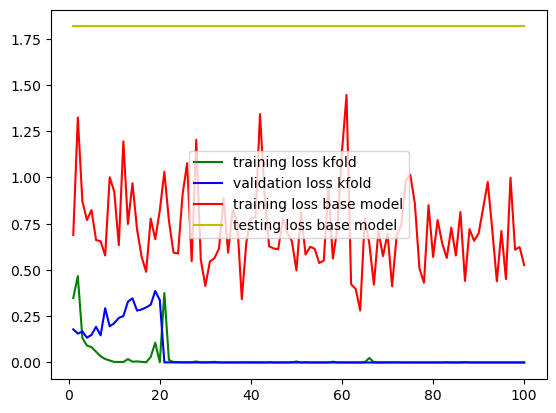

In [329]:
epochs=range(1,101)
#epochs2=range(1,len(training_losses_earlystopping)+1)
plt.plot(epochs,training_losses_kfold,'g',label='training loss kfold')
plt.plot(epochs,ans3,'b',label='validation loss kfold')
plt.plot(epochs,training_losses_base_model,'r',label='training loss base model')
plt.plot(epochs,ans,'y',label='testing loss base model')
plt.legend()
plt.show()

In [266]:
base_model.load_state_dict(torch.load(f'kfold.h5'))

<All keys matched successfully>

Now let's look at learning rate scheduler


In [333]:
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.
    for i, data in enumerate(training_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = base_model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 20 == 19:
            last_loss = running_loss/19  
#            print('  batch {} loss: {}'.format(i + 1, last_loss))
#             tb_x = epoch_index * len(training_loader) + i + 1
#             tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0
    return last_loss

In [336]:
dataset = TensorDataset(X_train_tensor, Y_train_tensor)
training_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
testing_best_loss=100000000
epoch_current=1
epochs=100
num_correct=0
num_samples=0
correct_epoch=[]
y_prediction=[]
y_true=[]
not_improving=0
optimizer=torch.optim.SGD(base_model.parameters(),lr=0.01)
scheduler=lr_scheduler.StepLR(optimizer,step_size=5,gamma=0.1)
training_losses_learning_rate_scheduler=[]
testing_losses_learning_rate_scheduler=[]
for epoch in range(epochs):
    t0=time.time()
    num_correct=0
    num_samples=0
    print(f'current epoch is {epoch_current}')
    base_model.train(True)
    train_loss=train_one_epoch(epoch_current)
    base_model.train(False)
    scheduler.step()
    print(f'training loss is {train_loss}')
    testing_loss=0
    total_testing_loss=0
    for i,testdata in enumerate(testing_loader):
        testinputs,testlabels=testdata
        testoutputs=base_model(testinputs)
        testloss=loss_fn(testoutputs,testlabels)
        total_testing_loss+=testloss
        avg_testing_loss=total_testing_loss/(i+1)
        predictions=(testoutputs>=0.5)
        num_correct+=(predictions==testlabels).sum()
        num_samples+=predictions.size(0)
        if (avg_testing_loss<testing_best_loss):
            testing_best_loss=avg_testing_loss
            best_model=base_model.state_dict()
            predictions=(testoutputs>0.5)
            correct_ones=((predictions==testlabels).sum())/(testlabels.size(dim=0))
    training_losses_learning_rate_scheduler.append(train_loss)
    testing_losses_learning_rate_scheduler.append(avg_testing_loss)
    correct_epoch.append(num_correct)
#     if(num_correct>max(correct_epoch)):
#         not_improving=0
#     else:
#         not_improving+=1
#     if(not_improving==3):
#         break
    
    epoch_current+=1
# for i,testdata in enumerate(testing_loader):
#     testinputs,testlabels=testdata
#     testoutputs=best_model(testinputs)
#     predictions=(testoutputs>0.5)
#     num_correct_final+=(predictions==testlabels).sum()
base_model1_lrs_time=time.time()-t0
print(f'time_taken is {base_model1_time}')
print(testing_best_loss)
print(num_correct)
print(correct_epoch)
print(correct_ones*100)

current epoch is 1
training loss is 0.685383959820396
current epoch is 2
training loss is 0.6734302608590377
current epoch is 3
training loss is 0.6201791935845425
current epoch is 4
training loss is 0.6491969917949877
current epoch is 5
training loss is 0.5043375931288067
current epoch is 6
training loss is 0.5710774518941578
current epoch is 7
training loss is 0.4112567270272656
current epoch is 8
training loss is 0.4291168686590697
current epoch is 9
training loss is 0.3748890718347148
current epoch is 10
training loss is 0.49613461996379654
current epoch is 11
training loss is 0.35199420742298426
current epoch is 12
training loss is 0.4184715563529416
current epoch is 13
training loss is 0.3949858338425034
current epoch is 14
training loss is 0.4134691118409759
current epoch is 15
training loss is 0.4075080250438891
current epoch is 16
training loss is 0.4713590403920726
current epoch is 17
training loss is 0.41280420908802434
current epoch is 18
training loss is 0.3168406780613096

In [343]:
ans=[ele.detach().numpy() for ele in testing_losses_base_model]
ans3=[ele.detach().numpy() for ele in testing_losses_learning_rate_scheduler]
len(ans3)

100

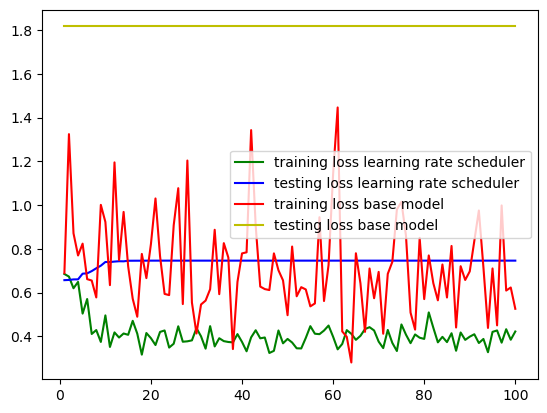

In [344]:
epochs=range(1,101)
plt.plot(epochs,training_losses_learning_rate_scheduler,'g',label='training loss learning rate scheduler')
plt.plot(epochs,ans3,'b',label='testing loss learning rate scheduler')
plt.plot(epochs,training_losses_base_model,'r',label='training loss base model')
plt.plot(epochs,ans,'y',label='testing loss base model')
plt.legend()
plt.show()

The accuracy is close to 80 percentage.

The training time is

In [294]:
model5_time-base_model1_lrs_time

0.2711198329925537

These optimisation models are a lot faster in terms of training time than the base model with no optimisation Method.

Only k-fold cross validation has the higher training time understandably since the each part of the training set is looped around 5 times either in the form of the training or validation set.

Team Member                 |             Assignment Part     |     Contribution

1. Nikhileswar Mada         |            I-II                 |       50%

2.Bharath Siva Sai Potru    |            I-II                 |       50%